In [1]:
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import List, Optional
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import yaml
import pandas as pd
import os
load_dotenv()
client = OpenAI()

In [2]:
class GameEvent(BaseModel):
    decision: bool

class History(GameEvent):
    period: int
    payoff: int

class Games(BaseModel):
    event: List[GameEvent] = Field(default_factory=list)

class GameHistory(BaseModel):
    history: List[History] = Field(default_factory=list)

def run_game(prompt,name=None,model="gpt-4o-mini",response_format=GameEvent):
    system_prompt = open("system_prompt.txt", "r").read()
    query = [
        {}
    ]
    try:
        response = client.beta.chat.completions.parse(
            model=model, 
            prompt=system_prompt, 
            query=query,
            response_format=response_format
            )
        results = response_format.model_validate_json(response.choices[0].message.content).model_dump()
        results['name'] = name
        results['model'] = model
        return results
    except Exception as e:
        raise e
    

# Calculate the payoff of the game
def calculate_payoff(events: Games):
    pass
    
# Given a collection of games and histories produce a summary of for the player
def get_history_summary(name, history: GameHistory):
    pass

# Run a round either with or without history
def run_round():
    pass

# Run a repeated game
def run_game(rounds=15):
    pass

In [3]:
model = "gpt-4o-mini"

def get_play_for_self(temperature=1):
    system_prompt = open('./prompts/system_prompt_1.txt').read()
    play_for_self = open('./prompts/play_for_self_2.txt').read()
    query=[
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': play_for_self}
    ]
    try:
        completion = client.beta.chat.completions.parse(
                    model=model,
                    messages=query,
                    temperature=temperature,
                    response_format=GameEvent
            )
    except Exception as e:
        print(e)
        return get_play_for_self(temperature)

    game_results = GameEvent.model_validate_json(completion.choices[0].message.content)
    results = game_results.model_dump()
    results['temperature'] = temperature
    results['added'] = results['decision'] == DecisionOption.ADD
    return results

def get_play_for_pair(temperature=1):
    system_prompt = open('./prompts/system_prompt_1.txt').read()
    play_for_self = open('./prompts/play_for_pair_2.txt').read()
    query=[
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': play_for_self}
    ]
    try:  
        completion = client.beta.chat.completions.parse(
                    model="gpt-4o-mini",
                    messages=query,
                    temperature=temperature,
                    response_format=GameEvent
            )
    except Exception as e:
        print(e)
        return get_play_for_pair(temperature)

    game_results = GameEvent.model_validate_json(completion.choices[0].message.content)
    results = game_results.model_dump()
    results['temperature'] = temperature
    results['added'] = results['decision'] == DecisionOption.ADD
    return results

In [4]:
play_for_pairs = []
for temperature in np.linspace(0.5,1.5,5):
    print(f"Temperature: {temperature}")
    for _ in range(10):
        play_for_pairs.append(get_play_for_pair(temperature))
play_for_pairs_df = pd.DataFrame(play_for_pairs)
play_for_pairs_df['added'].sum()

Temperature: 0.5


NameError: name 'DecisionOption' is not defined

In [ ]:
play_for_pairs_df.to_csv('./dist/play_for_pairs_2_6.csv', index=False)
play_for_pairs_df

,decision,note,temperature,added
0,DecisionOption.NOT_ADD,I believe maintaining the current network stru...,0.5,False
1,DecisionOption.NOT_ADD,I believe maintaining the current structure wi...,0.5,False
2,DecisionOption.NOT_ADD,I believe that maintaining the current structu...,0.5,False
3,DecisionOption.NOT_ADD,I believe maintaining the current structure wi...,0.5,False
4,DecisionOption.NOT_ADD,I believe maintaining the current structure is...,0.5,False
...,...,...,...,...
495,DecisionOption.ADD,I believe creating the connection will benefit...,1.5,True
496,DecisionOption.NOT_ADD,It is uncertain if the other decision-maker wi...,1.5,False
497,DecisionOption.NOT_ADD,Choosing not to add the bridge now will keep t...,1.5,False
498,DecisionOption.ADD,Creating the new connection maximizes benefits...,1.5,True


In [ ]:
play_for_self = []
for temperature in np.linspace(0.5,1.5,5):
    print(f"Temperature: {temperature}")
    for _ in range(10):
        play_for_self.append(get_play_for_pair(temperature))
play_for_self_df = pd.DataFrame(play_for_self)
play_for_self_df['added'].sum()

Temperature: 0.5
Temperature: 0.75
Temperature: 1.0
Temperature: 1.25
Temperature: 1.5


np.int64(55)

In [ ]:
play_for_self_df.to_csv('./dist/play_for_self_2_6.csv', index=False)
play_for_self_df

,decision,note,temperature,added
0,DecisionOption.NOT_ADD,I believe that maintaining the current structu...,0.5,False
1,DecisionOption.NOT_ADD,I believe maintaining the current structure en...,0.5,False
2,DecisionOption.NOT_ADD,I believe that leaving the network as it is wi...,0.5,False
3,DecisionOption.NOT_ADD,I believe that maintaining the current structu...,0.5,False
4,DecisionOption.NOT_ADD,I believe that maintaining the current structu...,0.5,False
...,...,...,...,...
495,DecisionOption.NOT_ADD,"By choosing not to modify the network, I prior...",1.5,False
496,DecisionOption.NOT_ADD,"After analyzing the situation, I believe that ...",1.5,False
497,DecisionOption.NOT_ADD,Based on the likely better outcomes and ensuri...,1.5,False
498,DecisionOption.NOT_ADD,"After considering the potential outcomes, it m...",1.5,False


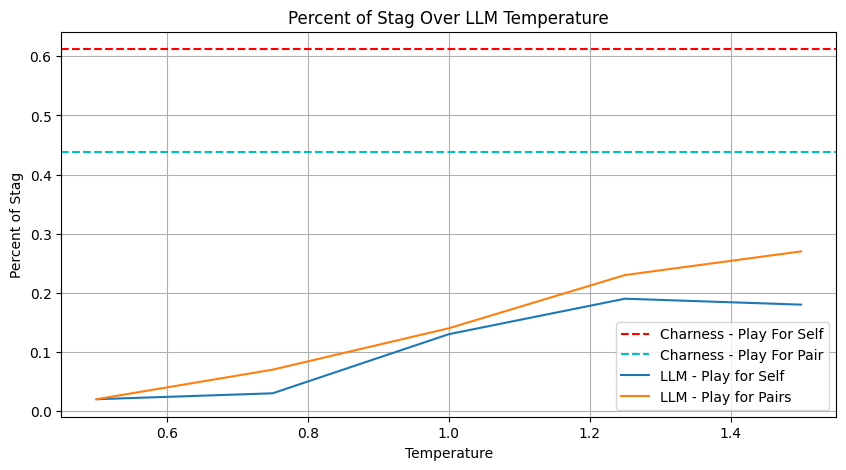

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Percent of Stag Over LLM Temperature")
plt.xlabel("Temperature")
plt.ylabel("Percent of Stag")
# Produce horizontal dashed line at 61.2%
plt.axhline(y=0.612, color='r', linestyle='--', label="Charness - Play For Self")
plt.axhline(y=0.439, color='c', linestyle='--', label="Charness - Play For Pair")

x,y = (play_for_self_df.groupby('temperature')['added'].sum()/100).reset_index().values.T
plt.plot(x,y, label="LLM - Play for Self")
x,y = (play_for_pairs_df.groupby('temperature')['added'].sum()/100).reset_index().values.T
plt.plot(x,y, label="LLM - Play for Pairs")
plt.legend()
plt.grid()

In [5]:
play_for_self = []
for _ in range(10):
    play_for_self.append(get_play_for_pair(temperature))
play_for_self_df = pd.DataFrame(play_for_self)
play_for_self_df.to_csv('./dist/play_for_self_070_2_2.csv', index=False)
play_for_self_df['added'].sum()

NameError: name 'DecisionOption' is not defined

In [ ]:
play_for_pairs = []
for _ in range(10):
    play_for_pairs.append(get_play_for_pair(temperature))
play_for_pairs_df = pd.DataFrame(play_for_pairs)
play_for_pairs_df.to_csv('./dist/play_for_pairs_070_2_2.csv', index=False)
play_for_pairs_df['added'].sum()

np.int64(218)

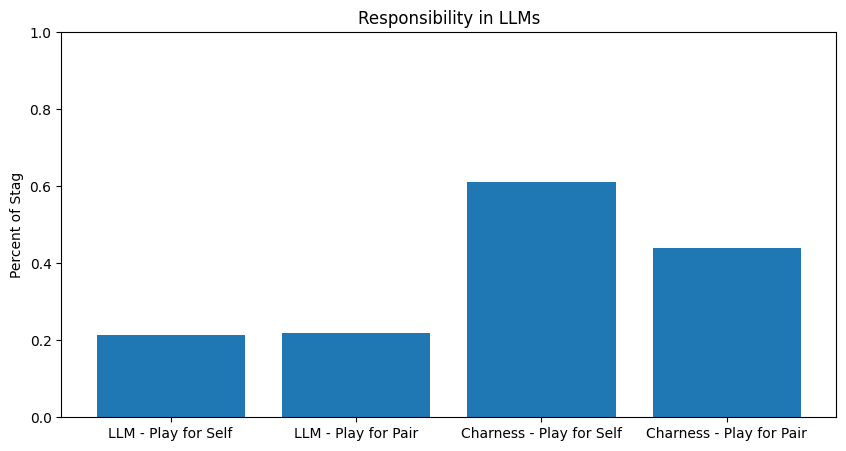

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Responsibility in LLMs")
# Bar chart of 4 values, 2 for LLM and 2 for Charness
# LLM Play for Self
# LLM Play for Pair
# Charness Play for Self
# Charness Play for Pair
x = np.arange(4)
y = [
    play_for_self_df['added'].sum()/len(play_for_self_df),
    play_for_pairs_df['added'].sum()/len(play_for_pairs_df),
    0.612,
    0.439
]
plt.bar(x,y)
plt.xticks(x, ['LLM - Play for Self', 'LLM - Play for Pair', 'Charness - Play for Self', 'Charness - Play for Pair'])
plt.ylabel("Percent of Stag")
plt.ylim(0,1)
plt.show()